# Building a Digital Orrery
## An exercise in Object Oriented Programming

**Version 0.1**

It is your goal in this exercise to construct a Digital Orrery. An [orrery](https://en.wikipedia.org/wiki/Orrery) is a mechanical model of the Solar System. Here, we will generalize this to anything that is mechanically similar to *the* solar system: a collection of things bound gravitationally. 


<img src="https://upload.wikimedia.org/wikipedia/commons/4/48/Grand_orrery_in_Putnam_Gallery%2C_2009-11-24.jpg" alt="Orrery" width="600"/>
(image: wikimedia)


* * *

By J. S. Oishi (Bates College)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

## Problem 1) Building a basic set of objects

Our first task is to map our problem onto a set of **objects** that we **instantiate** (that is, make **instances** of) in order to solve our problem.

Let's outline the scope of our problem.

A solar system exists in a Universe; here we can ignore the gravitational perturbation on the Solar System from the rest of the Universe. Our model will consist of a small number of bodies containing mass. It might also contain bodies without mass, so called "test particles".

The problem to be solved numerically is the gravitational N-body problem,

$$\ddot{\mathbf{r}}_i = -G\sum_{i \ne j} \frac{m_j \mathbf{r}_{ij}}{r_{ij}^3},$$

where $\mathbf{r}_{ij} \equiv \mathbf{r_i} - \mathbf{r_j}$. This task itself can be broken into two components: 

* the force calculation
* the ODE integrator to advance $\mathbf{r}_i$ and $\dot{\mathbf{r}}_i$ forward in time

**Problem 1a**

In disucssion with a classmate, sketch out a set of classes that you will need to complete this project. Don't worry about things like numerical integrators yet. 

Also, sketch out interfaces (start with the constructor), but don't worry about writing code right now.

*Once you're done, find me and I'll give you the minimal list of objects.*

In [154]:
class Body():
    def __init__(self, mass, position, velocity):
        self.mass = np.array(mass, dtype=np.float64)
        self.position = np.array(position, dtype=np.float64)
        self.velocity = np.array(velocity, dtype=np.float64)
        
    def accelerate(self, other, softening_length=1e-2):
        """Compute vector accleration between `other` and this body"""
        r = self.position - other.position
        return -G * other.mass * r / (np.linalg.norm(r+softening_length)**3)
    
#     def accumulate_acceleration(self, other_bodies):
#         """Sum all acclerations for `other_bodies` in system."""
#         return np.sum([self.accelerate(other) for other in other_bodies])

class TestMass(Body):
    def __init__(self, position, velocity):
        super().__init__(0, position, velocity)
        
class Universe():
    def __init__(self, bodies):
        if not hasattr(bodies, '__iter__'):
            self.bodies = [bodies, TestMass([0.5, -0.5, 0], [0, 0, 0])]
        elif len(bodies) == 1:
            self.bodies = [bodies[0], TestMass([0.5, -0.5, 0], [0, 0, 0])]
        else:
            self.bodies = bodies
    
    def move_all(self, integration_method='leapfrog', softening_length=1e-2):
        """Updates all positions and velocities"""

        if integration_method != 'leapfrog':
            raise NotImplementedError("Sorry, I haven't implemented this yet!")
            
        for body in self.bodies:
            other_bodies = list(filter(lambda b: b != body, self.bodies))
                        
            # dynamical time step
            dt = np.median([np.abs(body.position - other.position) + softening_length for other in other_bodies]) / 4
            
            # update positions
            current_acceleration = np.sum([body.accelerate(other, softening_length) for other in other_bodies])
            body.position += dt * body.velocity + 0.5 * dt**2 * current_acceleration
            
            # update velocities
            body.velocity += 0.5 * dt * (current_acceleration + np.sum([body.accelerate(other, softening_length) for other in other_bodies]))
    

**Problem 1b**

Wire them up! Now that you have the list, try them out. Python makes use of duck typing, you should too. That is, if your object has a mass `m`, a position `r` and a velocity `rdot`, it *is* a Body.

In [87]:
r0 = np.array([0,0,0])
rdot0 = np.array([0,0,0])

In [88]:
b = Body(1,r0, rdot0)

## Problem 2

Now, we code the numerical algorithms. We're going to do the most simple things possible: a *brute force* ("direct N-Body" if you're feeling fancy) force calculation, and a leapfrog time integrator.

The leapfrog scheme is an explicit, second order scheme given by

$$r_{i+1} = r_{i} + v_{i} \Delta t + \frac{\Delta t^2}{2} a_{i}$$

$$v_{i+1} = v_{i} + \frac{\Delta t}{2} (a_{i} + a_{i+1}),$$

where $\Delta t$ is the time step (which we'll just keep constant), and the subscript refers to the *iteration* number $i$. 

Note that this scheme requires a force update *in between* calculating $r_{i+1}$ and $v_{i+1}$.

**Problem 2a** 

Write a method that implements the force integrator. Test it on simple cases:
 * two equal 1 $M_\odot$ objects in your universe, 1 AU apart
 * a $1\ M_\odot$ object and a $1\ M_{\oplus}$ object, 1 AU apart

In [102]:
# define constants
G = 1.


In [113]:
b3 = TestMass([0.5, -0.3, 0], [1., 0, 0])

**Problem 2b**
Write the leapfrog integration as a method in the `Universe` class. Test it on one particle with no force (what should it do?)

In [171]:
# mass in unit of M_sun, r in units of AU
sun1 = Body(1, [0, 0, 0], [0, 0, 0])
sun2 = Body(1, [0, 1, 0], [0, 0, 0])

uni1 = Universe([sun1, sun2])

In [172]:
uni1.bodies[1].position

array([0., 1., 0.])

In [173]:
for t in np.arange(0,2000):
    uni1.move_all()
    if t % 100 == 0:
        print(uni1.bodies[1].velocity)

[-0.00242654 -0.00242654 -0.00242654]
[0.10062208 0.10062208 0.10062208]
[0.24441657 0.24441657 0.24441657]
[0.57277189 0.57277189 0.57277189]
[-0.15050256 -0.15050256 -0.15050256]
[0.0439288 0.0439288 0.0439288]
[0.1389498 0.1389498 0.1389498]
[0.20435345 0.20435345 0.20435345]
[0.25005594 0.25005594 0.25005594]
[0.27249608 0.27249608 0.27249608]
[0.25052766 0.25052766 0.25052766]
[0.02972277 0.02972277 0.02972277]
[0.77888724 0.77888724 0.77888724]
[0.55689146 0.55689146 0.55689146]
[0.17167968 0.17167968 0.17167968]
[0.66404601 0.66404601 0.66404601]
[0.99639659 0.99639659 0.99639659]
[1.2089218 1.2089218 1.2089218]
[1.15113439 1.15113439 1.15113439]
[0.85146966 0.85146966 0.85146966]


**Problem 2c** 
 
Wire it all up! Try a 3-body calculation of the Earth-Sun-Moon system. Try the Earth-Jupiter-Sun system! 

In [174]:
earthsunmoon = Universe([Body(1, [0, 0], [0, 0]),
                         Body(1e-3, [1, 0], [0.05, -0.05]),
                         Body(1e-4, [1.00001, 0], [0.0499998, -0.050002])]
                       )


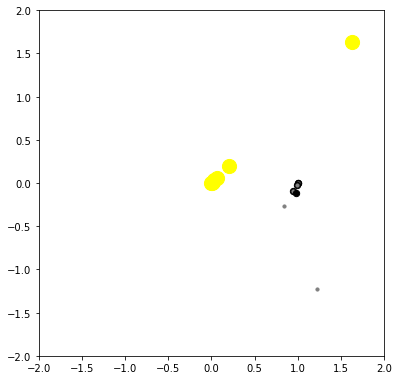

In [175]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)


for t in np.arange(0, 2000):
    earthsunmoon.move_all()
    
    if t % 20 == 0:
        [sun, earth, moon] = earthsunmoon.bodies
        ax.scatter(*sun.position, s=200, c='yellow')
        ax.scatter(*earth.position, s=40, c='k')
        ax.scatter(*moon.position, s=10, c='gray')

## Challenge Problem

* Construct a visualization method for the `Universe` class
* Read about the Fast Multipole Method (FMM) [here](https://math.nyu.edu/faculty/greengar/shortcourse_fmm.pdf) and implement one for the force calculation

In [ ]:
# good luck!